<a href="https://colab.research.google.com/github/Biel-Maia/Pesquisa-Operacional/blob/main/C%C3%B3pia_de_Pesquisa_Operacional_mais_grupos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Otimização do Planejamento de Treino Baseada no Custo Cardíaco

**Alunos:**


*   Gabriel Henrique Silva Maia
*   Igor Braga de Lima
*   Talvani de Souza Barbosa
*   Matheus Gregor Dias Carvalho Costa


In [ ]:
!pip install gurobipy pandas matplotlib openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum
import numpy as np
import re # Para extrair o ID da planilha do link
from urllib.error import HTTPError # Importar para capturar o erro específico
import time
from datetime import timedelta

def ler_planilha(url_compartilhamento: str, sheet_name: str | int = 0):
    """
    Lê uma planilha pública do Google Sheets (que pode ser um arquivo XLSX compartilhado ou
    uma planilha Google que pode ser exportada como XLSX) diretamente para um DataFrame do Pandas,
    sem autenticação.

    Args:
        url_compartilhamento (str): link de compartilhamento da planilha/arquivo.
        sheet_name (str | int): nome da aba

    Returns:
        pd.DataFrame
    """
    id_arquivo = None
    padrao_id = r"/(?:spreadsheets|file)/d/([a-zA-Z0-9-_]+)"
    correspondencia = re.search(padrao_id, url_compartilhamento)

    if correspondencia:
        id_arquivo = correspondencia.group(1)
    else:
        print(f"Erro: Não foi possível encontrar o ID do arquivo no link de compartilhamento: {url_compartilhamento}")
        return None

    url_xlsx = f'https://docs.google.com/spreadsheets/d/{id_arquivo}/export?format=xlsx'
    df = None
    try:
        df = pd.read_excel(url_xlsx, sheet_name=sheet_name)
        print(f"Planilha/Aba '{sheet_name}' lida com sucesso para um DataFrame!")
    except HTTPError as e:
        print(f"Erro HTTP ao ler a planilha {url_xlsx}: {e}")
        print("Verifique se o link está correto e se a planilha está configurada para compartilhamento público ou 'Qualquer pessoa com o link'.")
    except Exception as e:
        print(f"Ocorreu um erro ao ler a planilha {url_xlsx}: {e}")
    return df

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 92.4 MB/s eta 0:00:00


# Leitura e processamento de dados



*   Importa planilhas de custo dos exercícios e de divisão muscular
*   Mapeia os exercicios de acordo com os grupos musculares discretizados



In [ ]:
df_custo = ler_planilha('https://docs.google.com/spreadsheets/d/1x4pnPpOrN8we9nbMYgX0Q2t0yF2vuGBi/edit?usp=sharing&ouid=100059752205330745744&rtpof=true&sd=true')
df_grupo = ler_planilha('https://docs.google.com/spreadsheets/d/1Xc6e-sKu_ofsD5fdKX2uOCYe6_EIZRmxf6VkRBhPk2Q/edit?usp=sharing')
if df_custo is None or df_grupo is None:
    print("Erro ao carregar planilhas.")
    exit()


# Filtrar df_grupo para conter apenas exercícios presentes em df_custo e definir 'Exercício' como índice
df_grupo = df_grupo[df_grupo['Exercício'].isin(df_custo['Exercício'])]
df_grupo.set_index('Exercício', inplace=True)

display(df_custo)
display(df_grupo)


Planilha/Aba '0' lida com sucesso para um DataFrame!
Planilha/Aba '0' lida com sucesso para um DataFrame!


,Exercício,Grupo Muscular,DIF,Nível
0,Terra,Costas,44,4
1,Hack,Pernas,35,4
2,Agachamento livre,Pernas,52,4
3,Extensora,Pernas,17,2
4,Leg press,Pernas,32,4
5,Panturrilha no banco solear,Pernas,6,1
6,Cadeira adutora,Pernas,24,3
7,Cadeira flexora,Pernas,27,3
8,Cadeira abdutora,Pernas,37,4
9,Mesa flexora,Pernas,17,2


,Peito,Costas,Ombros,Bíceps,Tríceps,Quadríceps,Isquiotibiais,Glúteos,Panturrilhas,Adutores,Abdutores
Exercício,,,,,,,,,,,
Terra,0,1,0,0,0,1,1,1,0,0,0
Hack,0,0,0,0,0,1,0,1,0,0,0
Agachamento livre,0,1,0,0,0,1,1,1,0,1,1
Extensora,0,0,0,0,0,1,0,0,0,0,0
Leg press,0,0,0,0,0,1,0,1,0,0,0
Panturrilha no banco solear,0,0,0,0,0,0,0,0,1,0,0
Cadeira adutora,0,0,0,0,0,0,0,0,0,1,0
Cadeira flexora,0,0,0,0,0,0,1,0,0,0,0
Cadeira abdutora,0,0,0,0,0,0,0,1,0,0,1


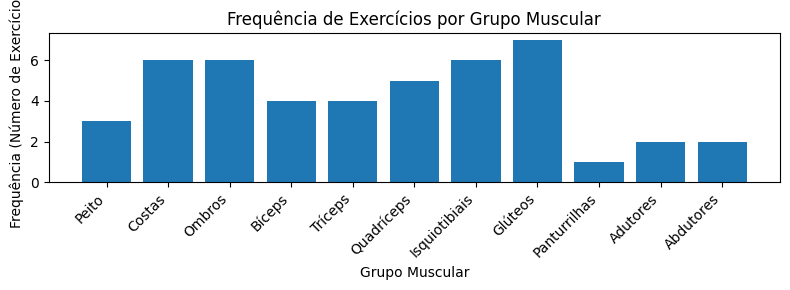

In [ ]:
muscle_group_columns = df_grupo.columns
frequencies = df_grupo[muscle_group_columns].sum(axis=0)
grupos_nomes_plot = frequencies.index
plt.figure(figsize=(8, 3))
plt.bar(grupos_nomes_plot, frequencies)
plt.xlabel('Grupo Muscular')
plt.ylabel('Frequência (Número de Exercícios)')
plt.title('Frequência de Exercícios por Grupo Muscular')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
map_exercicio_para_conjunto_grupos = {}
for exercicio_nome in df_grupo.index:
    conjunto_grupos_exercicio = set(df_grupo.loc[exercicio_nome][df_grupo.loc[exercicio_nome] > 0].index)
    map_exercicio_para_conjunto_grupos[exercicio_nome] = conjunto_grupos_exercicio


#Cria C
df_custo['Grupo Muscular'] = df_custo['Exercício'].map(map_exercicio_para_conjunto_grupos)
df_custo['Grupo Muscular'] = df_custo['Grupo Muscular'].apply(lambda x: x if isinstance(x, (set, frozenset)) else set())
df_custo["ID"] = df_custo.index + 1
exercicios = df_custo["ID"].tolist() # Lista de IDs numéricos dos exercícios
C = pd.Series(df_custo['Nível'].values, index=df_custo['ID']).to_dict() # Custo por ID de exercício


#group_map
todos_nomes_grupos_individuais = set()
for conjunto_grupos_exercicio in df_custo['Grupo Muscular']:
    if isinstance(conjunto_grupos_exercicio, (set, frozenset)):
        todos_nomes_grupos_individuais.update(conjunto_grupos_exercicio)

lista_nomes_grupos_unicos = sorted(list(todos_nomes_grupos_individuais))
group_map = {nome: idx + 1 for idx, nome in enumerate(lista_nomes_grupos_unicos)}
grupos = list(group_map.values())
print(f"Group_map: {group_map}")
print(f"Grupo: {grupos}")

#Cria G
def map_nomes_para_ids(conjunto_nomes, g_map):
    if isinstance(conjunto_nomes, (set, frozenset)):
        return {g_map[nome] for nome in conjunto_nomes if nome in g_map}
    return set()

df_custo["GrupoID_Set"] = df_custo["Grupo Muscular"].apply(lambda s: map_nomes_para_ids(s, group_map))
G = pd.Series(df_custo['GrupoID_Set'].values, index=df_custo['ID']).to_dict()

Group_map: {'Abdutores': 1, 'Adutores': 2, 'Bíceps': 3, 'Costas': 4, 'Glúteos': 5, 'Isquiotibiais': 6, 'Ombros': 7, 'Panturrilhas': 8, 'Peito': 9, 'Quadríceps': 10, 'Tríceps': 11}
Grupo: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [ ]:
print("\n--- Dados Carregados e Processados para o Modelo ---")
print(f"Exercícios (IDs): {exercicios}")
print(f"Custo Cardíaco por Exercício (C): {C}")
print(f"Todos os IDs Numéricos de Grupos Musculares Únicos (grupos): {grupos}")
print(f"Mapeamento Nome do Grupo Muscular -> ID Numérico (group_map): {group_map}")
print(f"Mapeamento ID do Exercício -> Conjunto de IDs Numéricos de Grupo (G):")
for ex_id, grp_ids in G.items():
    print(f"  Ex. {ex_id}: {grp_ids}")
print("----------------------------------------------------")


--- Dados Carregados e Processados para o Modelo ---
Exercícios (IDs): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Custo Cardíaco por Exercício (C): {1: 4, 2: 4, 3: 4, 4: 2, 5: 4, 6: 1, 7: 3, 8: 3, 9: 4, 10: 2, 11: 2, 12: 4, 13: 1, 14: 2, 15: 1, 16: 1, 17: 2, 18: 3, 19: 1, 20: 1, 21: 2, 22: 3}
Todos os IDs Numéricos de Grupos Musculares Únicos (grupos): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Mapeamento Nome do Grupo Muscular -> ID Numérico (group_map): {'Abdutores': 1, 'Adutores': 2, 'Bíceps': 3, 'Costas': 4, 'Glúteos': 5, 'Isquiotibiais': 6, 'Ombros': 7, 'Panturrilhas': 8, 'Peito': 9, 'Quadríceps': 10, 'Tríceps': 11}
Mapeamento ID do Exercício -> Conjunto de IDs Numéricos de Grupo (G):
  Ex. 1: {10, 4, 5, 6}
  Ex. 2: {10, 5}
  Ex. 3: {1, 2, 4, 5, 6, 10}
  Ex. 4: {10}
  Ex. 5: {10, 5}
  Ex. 6: {8}
  Ex. 7: {2}
  Ex. 8: {6}
  Ex. 9: {1, 5}
  Ex. 10: {6}
  Ex. 11: {5, 6}
  Ex. 12: {4, 5, 6}
  Ex. 13: {9}
  Ex. 14: {9, 11, 7}
  Ex. 15: {9, 11, 7}
  Ex. 16

# Definição dos Parâmetros

In [ ]:
E_min = 4  # Número mínimo de exercícios por dia de treino
E_max = 10  # Número máximo de exercícios por dia de treino

D_min = 4  # Número mínimo de dias de treino na semana
D_max = 6  # Número máximo de dias de treino na semana

C_min_daily = 8  # Carga cardíaca ('Nível') mínima por dia de treino
C_max_daily = 12 # Carga cardíaca ('Nível') máxima por dia de treino

Frequencia_semanal_min_exercicios = 1   # Minima quantidade de vezes que o exercício deve ser realizado na semana
Frequencia_semanal_max_exercicios = 3   # Maxima quantidade de vezes que o exercício deve ser realizado na semana

S_min = {}
S_min[group_map["Abdutores"]] = 4
S_min[group_map["Adutores"]] = 4
S_min[group_map["Bíceps"]] = 12
S_min[group_map["Costas"]] = 18
S_min[group_map["Glúteos"]] = 14
S_min[group_map["Isquiotibiais"]] = 12
S_min[group_map["Ombros"]] = 12
S_min[group_map["Panturrilhas"]] = 2
S_min[group_map["Peito"]] = 8
S_min[group_map["Quadríceps"]] = 10
S_min[group_map["Tríceps"]] = 6

print(f"\nVolume Mínimo Semanal por Grupo (S_min, IDs Numéricos): {S_min}")
S = {i: 2 for i in exercicios} # S[i] são as séries para o exercício i


Volume Mínimo Semanal por Grupo (S_min, IDs Numéricos): {1: 4, 2: 4, 3: 12, 4: 18, 5: 14, 6: 12, 7: 12, 8: 2, 9: 8, 10: 10, 11: 6}


# Modelagem do Problema de Otimização


*   Modelo e variáveis binárias
*   Função Objetivo
*   Restrições



In [ ]:
#MODELO
model = Model("Planejamento_Treino_MultiGrupo_Sinergia")
X = {}  # X[i, j] = 1 se o exercício i é feito no dia j, 0 CC
for i in exercicios:
    for j in range(1, 8): # Dias 1 a 7
        X[i, j] = model.addVar(vtype=GRB.BINARY, name=f"X_{i}_{j}")

Y = {}  # Y[j] = 1 se o dia j é um dia de treino, 0 caso contrário
for j in range(1, 8):
    Y[j] = model.addVar(vtype=GRB.BINARY, name=f"Y_{j}")

Z = {}  # Z[g, j] = 1 se o grupo muscular g (ID numérico) é treinado no dia j, 0 caso contrário
for g in grupos: # 'grupos' é a lista de IDs numéricos de grupos
    for j in range(1, 8):
        Z[g, j] = model.addVar(vtype=GRB.BINARY, name=f"Z_{g}_{j}")

model.update()

obj = quicksum(C[i] * X[i, j] for i in exercicios for j in range(1, 8))
model.setObjective(obj, GRB.MINIMIZE)

#RESTRIÇÕES
# R1: Ligar Z[g,j] com X[i,j]
for g in grupos:
    exercises_working_group_g = [i for i in exercicios if g in G[i]]
    if exercises_working_group_g:
        for j in range(1, 8):
            model.addConstr(quicksum(X[i, j] for i in exercises_working_group_g) <= len(exercises_working_group_g) * Z[g, j], name=f"link_Z_upper_{g}_{j}")
            model.addConstr(Z[g, j] <= quicksum(X[i, j] for i in exercises_working_group_g), name=f"link_Z_lower_{g}_{j}")

# R2: Limites de número de exercícios por dia de treino
for j in range(1, 8):
    soma_Xij_no_dia_j = quicksum(X[i, j] for i in exercicios)
    model.addConstr(soma_Xij_no_dia_j >= E_min * Y[j], name=f"minExercicios_dia_{j}")
    model.addConstr(soma_Xij_no_dia_j <= E_max * Y[j], name=f"maxExercicios_dia_{j}")

# R3: Frequência semanal por exercício (cada exercício deve ser feito pelo menos uma vez, máximo 3 vezes)
for i in exercicios:
    soma_Xij_por_exercicio_i = quicksum(X[i, j] for j in range(1, 8))
    model.addConstr(soma_Xij_por_exercicio_i >= Frequencia_semanal_min_exercicios, name=f"freqMin_ex_{i}")
    model.addConstr(soma_Xij_por_exercicio_i <= Frequencia_semanal_max_exercicios, name=f"freqMax_ex_{i}")
# R4: Ligar X[i,j] com Y[j] (um exercício só pode ser feito em um dia de treino)
for i in exercicios:
    for j in range(1, 8):
        model.addConstr(X[i, j] <= Y[j], name=f"liga_Xij_Yj_{i}_{j}")

# R5: Limites de dias de treino na semana
soma_Yj = quicksum(Y[j] for j in range(1, 8))
model.addConstr(soma_Yj >= D_min, name="minDiasTreino")
model.addConstr(soma_Yj <= D_max, name="maxDiasTreino")

# R6: Volume mínimo semanal por grupo muscular (S_min)
for g in grupos:
    exercises_working_group_g = [i for i in exercicios if g in G[i]]
    if exercises_working_group_g and g in S_min:
        termos_volume_grupo_g = quicksum(S[i] * X[i, j] for i in exercises_working_group_g for j in range(1, 8))
        model.addConstr(termos_volume_grupo_g >= S_min[g], name=f"volMin_grupo_{g}")


# R7: Limites de carga cardíaca ('Nível') diária
for j in range(1, 8):
    soma_Cj_no_dia_j = quicksum(C[i] * X[i, j] for i in exercicios)
    model.addConstr(soma_Cj_no_dia_j >= C_min_daily * Y[j], name=f"minCargaDiaria_dia_{j}")
    model.addConstr(soma_Cj_no_dia_j <= C_max_daily * Y[j], name=f"maxCargaDiaria_dia_{j}")


# R8: Restrições de Sinergia Muscular (Exemplo: Peito, Ombro, Tríceps não em dias consecutivos)

synergy_sets_config = []
  #Conjunto 1: Peito, Ombro, Tríceps (se existirem no group_map)
set1_nomes = ["Peito", "Ombro", "Tríceps"]
set1_ids = [group_map[nome] for nome in set1_nomes if nome in group_map]
synergy_sets_config.append(set1_ids)

  #Conjunto 2: Costas, Bíceps
set2_nomes = ["Costas", "Bíceps"] # Ou ["Costas", "Bíceps"]
set2_ids = [group_map[nome] for nome in set2_nomes if nome in group_map]
synergy_sets_config.append(set2_ids)

#Conjunto 3: Isquiotibiais, Glúteos, Costas
set3_nomes = ["Isquiotibiais", "Glúteos", "Costas"]
set3_ids= [group_map[nome] for nome in set3_nomes if nome in group_map]
synergy_sets_config.append(set3_ids)


for syn_set in synergy_sets_config:
    for idx1 in range(len(syn_set)):
        for idx2 in range(idx1 + 1, len(syn_set)):
            g1_id = syn_set[idx1]
            g2_id = syn_set[idx2]
            # Não treinar g1 e g2 em dias consecutivos (g1 no dia j, g2 no dia j+1 OU g2 no dia j, g1 no dia j+1)
            for j_day in range(1, 7): # Dias 1 a 6 (para j+1 ir até 7)
                # Z[g1_id, j_day] + Z[g2_id, j_day+1] <= 1  (Se g1 treinado hoje, g2 não pode ser treinado amanhã)
                # Z[g2_id, j_day] + Z[g1_id, j_day+1] <= 1  (Se g2 treinado hoje, g1 não pode ser treinado amanhã)
                if g1_id in Z and g2_id in Z :
                     model.addConstr(Z[g1_id, j_day] + Z[g2_id, j_day+1] <= 1, name=f"synergy_{g1_id}_{g2_id}_day{j_day}-{j_day+1}")
                     model.addConstr(Z[g2_id, j_day] + Z[g1_id, j_day+1] <= 1, name=f"synergy_{g2_id}_{g1_id}_day{j_day}-{j_day+1}")


# R9: Descanso para TODOS os grupos musculares (não treinar o MESMO grupo em dias consecutivos)
for g in grupos: # Para cada ID numérico de grupo
    for j_day in range(1, 7):
        model.addConstr(Z[g, j_day] + Z[g, j_day+1] <= 1, name=f"descanso_grupo_{g}_dia{j_day}-{j_day+1}")
    model.addConstr(Z[g, 7] + Z[g, 1] <= 1, name=f"descanso_grupo_{g}_dia7-1")


Restricted license - for non-production use only - expires 2027-11-29


# Otimização


*   Busca por umapool de soluções que contêm a solução otima(ou as soluções otimas em caso de multiplas soluções com memsmo custo ótimo)
*   Caso inviável, retorna análise das restrições



In [ ]:
# Otimizar o modelo
print("\n--- Otimizando o Modelo ---")
model.setParam(GRB.Param.PoolSearchMode, 2)  # Procura por todas as soluções ótimas
model.setParam(GRB.Param.PoolSolutions, 2000) # Armazena até 12000 soluções ótimas
model.optimize()
num_optimal_solutions = 0
try:
  optimal_obj_val = model.ObjVal # Valor da primeira solução ótima encontrada
except:
  pass
print('----------------------------------------------------------------')
if model.SolCount > 0:

  print(f"Encontradas {model.SolCount} soluções no pool.")

  for i in range(model.SolCount):
      model.setParam(GRB.Param.SolutionNumber, i)
      current_obj_val = model.PoolObjVal
      if abs(current_obj_val - optimal_obj_val) < 1e-6:
          num_optimal_solutions += 1


  print(f"Número de soluções ótimas distintas encontradas: {num_optimal_solutions}")
  print('----------------------------------------------------------------')


# Resultados da Otimização
print("\n--- Resultados da Otimização ---")
if model.status == GRB.OPTIMAL:
    print(f"Solução ótima encontrada. Custo cardíaco total ('Nível' somado): {model.objVal:.2f}")
    print("\nPlano de Treino Semanal:")
    # Criar um mapeamento reverso de ID de exercício para nome do exercício
    id_to_exercicio_name = pd.Series(df_custo['Exercício'].values, index=df_custo['ID']).to_dict()

    for j_day_result in range(1, 8):
        exercicios_no_dia_ids = [i_ex for i_ex in exercicios if X[i_ex, j_day_result].X > 0.5]
        if exercicios_no_dia_ids:
            nomes_exercicios_dia = [id_to_exercicio_name[idx] for idx in exercicios_no_dia_ids]
            custo_dia = sum(C[i_ex_costo] for i_ex_costo in exercicios_no_dia_ids)

            # Identificar grupos trabalhados no dia
            grupos_trabalhados_no_dia_ids = set()
            for ex_id_feito in exercicios_no_dia_ids:
                grupos_trabalhados_no_dia_ids.update(G[ex_id_feito]) # G[ex_id_feito] é um conjunto de IDs de grupo

            # Mapear IDs de grupo para nomes para exibição
            nomes_grupos_trabalhados = sorted([nome for nome, id_num in group_map.items() if id_num in grupos_trabalhados_no_dia_ids])

            print(f"Dia {j_day_result}: {nomes_exercicios_dia} ")#(Custo Nível: {custo_dia:.2f}) - Grupos: {nomes_grupos_trabalhados}
        else:
            print(f"Dia {j_day_result}: Descanso")



elif model.status == GRB.INFEASIBLE:
    print("Modelo inviável. Não foi possível encontrar uma solução com as restrições atuais.")
    model.computeIIS()
    iis_constrs = [c.ConstrName for c in model.getConstrs() if c.IISConstr]
    iis_vars = [v.VarName for v in model.getVars() if v.IISLB > 0 or v.IISUB > 0]

    print("\n--- Sugestões de Ajustes de Restrições ---")
    if not iis_constrs and not iis_vars:
        print("Não foi possível identificar um conjunto específico de restrições conflitantes com o IIS.")
        print("Isso pode acontecer em modelos com problemas numéricos. Verifique os parâmetros gerais do modelo.")
    else:
        print("As seguintes restrições ou limites de variáveis estão em conflito:")
        sugestoes = {
            'link_Z_upper_': "Verifique se as restrições de volume (R6), frequência de exercícios (R3), ou sinergia (R8/R9) não estão impedindo a inclusão de exercícios para um grupo muscular em um dia onde ele é exigido.",
            'link_Z_lower_': "Verifique se as restrições de volume (R6), frequência de exercícios (R3), ou sinergia (R8/R9) não estão impedindo a inclusão de exercícios para um grupo muscular em um dia onde ele é exigido.",
            'minExercicios_dia': "Aumente o número mínimo de exercícios permitidos por dia de treino (`E_min`).",
            'maxExercicios_dia': "Aumente o número máximo de exercícios permitidos por dia de treino (`E_max`).",
            'freqMin_ex': "Diminua a frequência mínima semanal exigida para um exercício específico (`Frequencia_semanal_min_exercicios`).",
            'freqMax_ex': "Aumente a frequência máxima semanal permitida para um exercício específico (`Frequencia_semanal_max_exercicios`).",
            'minDiasTreino': "Diminua o número mínimo de dias de treino na semana (`D_min`).",
            'maxDiasTreino': "Aumente o número máximo de dias de treino na semana (`D_max`).",
            'volMin_grupo': "Diminua o volume mínimo semanal exigido para um grupo muscular específico (`S_min`).",
            'minCargaDiaria_dia': "Diminua a carga cardíaca mínima ('Nível') exigida por dia de treino (`C_min_daily`).",
            'maxCargaDiaria_dia': "Aumente a carga cardíaca máxima ('Nível') permitida por dia de treino (`C_max_daily`).",
            'synergy_': "Relaxe as restrições de sinergia muscular, permitindo que certos pares de grupos musculares sinérgicos sejam treinados em dias consecutivos.",
            'descanso_grupo_': "Relaxe a restrição de descanso para um grupo muscular específico, permitindo que ele seja treinado em dias consecutivos."
        }

        sugestoes_emitidas = set()

        for nome_constr in iis_constrs:
            sugestao_encontrada = False
             # Tenta encontrar uma sugestão baseada no prefixo (mais geral para link/synergy/descanso)
            for chave, valor in sugestoes.items():
                if nome_constr.startswith(chave):
                    print(f"- {valor} (Conflito relacionado a: '{nome_constr}')")
                    sugestoes_emitidas.add(valor)
                    sugestao_encontrada = True
                    break


            if not sugestao_encontrada:
                # Se não encontrou por prefixo, verifica se é uma das restrições R2-R7 com nome exato
                if nome_constr in sugestoes and sugestoes[nome_constr] not in sugestoes_emitidas:
                     print(f"- {sugestoes[nome_constr]} (Conflito na restrição '{nome_constr}')")
                     sugestoes_emitidas.add(sugestoes[nome_constr])
                     sugestao_encontrada = True
                     break


            if not sugestao_encontrada:
                print(f"- Existe um conflito na restrição chamada '{nome_constr}'. Analise sua definição no modelo.")



--- Otimizando o Modelo ---
Set parameter PoolSearchMode to value 2
Set parameter PoolSolutions to value 2000
Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (linux64 - "Ubuntu 22.04.5 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
PoolSolutions  2000
PoolSearchMode  2

Optimize a model with 470 rows, 238 columns and 2548 nonzeros (Min)
Model fingerprint: 0x5e7a0695
Model has 154 linear objective coefficients
Variable types: 0 continuous, 238 integer (238 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]

Presolve removed 15 rows and 7 columns
Presolve time: 0.01s
Presolved: 455 rows, 231 columns, 2513 nonzeros
Variable types: 0 continuous, 231 integer (231 binary)

Root relaxation: objective 5.900000e+01, 251 iterations, 0.00 seconds (0.00 work units

In [ ]:
print("--- ANÁLISE PÓS-OTIMIZAÇÃO ---")

if model.Status == GRB.OPTIMAL:
    constraints_data = [] # Lista para armazenar dados para o DataFrame
    constraints_to_tighten = []

    for c in model.getConstrs():
        slack = c.Slack
        sense_char = c.Sense
        sense_str = '<=' if sense_char == GRB.LESS_EQUAL else '>=' if sense_char == GRB.GREATER_EQUAL else '=='
        rhs = c.RHS
        activity = model.getRow(c).getValue() # Valor do LHS da restrição
        is_active = abs(slack) < 1e-6

        constraints_data.append({
            "Nome da Restrição": c.ConstrName,
            "LHS (Atividade)": activity,
            "Sentido": sense_str,
            "RHS": rhs,
            "Folga (Slack)": slack,
            "Ativa?": "Sim" if is_active else "Não"
        })



        if is_active:
          continue
        else:
            constraints_to_tighten.append({
                "name": c.ConstrName,
                "slack": slack,
                "sense": sense_char, # Usar o char para a lógica de sugestão
                "rhs": rhs,
                "activity": activity
            })



    # Criar e exibir o DataFrame com as informações das restrições
    if constraints_data:
        print("\n--- RESUMO DAS RESTRIÇÕES EM DATAFRAME ---")
        df_constraints = pd.DataFrame(constraints_data)
        # Ajustar a ordem das colunas para melhor visualização
        df_constraints = df_constraints[["Nome da Restrição", "LHS (Atividade)", "Sentido", "RHS", "Folga (Slack)", "Ativa?"]]
        # Ordenar por folga (maior primeiro) para destacar as mais inativas
        df_constraints = df_constraints.sort_values(by="Folga (Slack)", ascending=False).reset_index(drop=True)


df_constraints[df_constraints['Ativa?']=='Não'].sort_values(by='Folga (Slack)', ascending=False, key=abs)[:10]

--- ANÁLISE PÓS-OTIMIZAÇÃO ---

--- RESUMO DAS RESTRIÇÕES EM DATAFRAME ---


,Nome da Restrição,LHS (Atividade),Sentido,RHS,Folga (Slack),Ativa?
0,maxExercicios_dia_5,-6.0,<=,0.0,6.0,Não
1,link_Z_upper_5_2,-5.0,<=,0.0,5.0,Não
2,maxExercicios_dia_7,-5.0,<=,0.0,5.0,Não
3,maxExercicios_dia_2,-5.0,<=,0.0,5.0,Não
4,link_Z_upper_6_2,-5.0,<=,0.0,5.0,Não
5,link_Z_upper_5_5,-5.0,<=,0.0,5.0,Não
6,link_Z_upper_5_7,-4.0,<=,0.0,4.0,Não
7,link_Z_upper_7_4,-4.0,<=,0.0,4.0,Não
8,link_Z_upper_6_4,-4.0,<=,0.0,4.0,Não
9,link_Z_upper_10_7,-4.0,<=,0.0,4.0,Não
